# Camera robot kalibratie

> Uit vorige opdrachten hebben we gezien hoe we metrische coördinaten uit een arbitrair frame kunnen projecteren in pixelcoördinaten door gebruik te maken van de intrinsieke en extrinsieke camera matrix. Omgekeerd kunnen we dus ook objecten gezien vanuit de camera projecteren in een ander frame door de bekomen matrix ${}^{C}T_{T}$ te inverteren tot matrix ${}^{T}T_{C}$. Deze zet dus punten in camera frame of in target frame. 

$$ {}^{T}P = {}^{T}T_{C}*{}^{C}P$$

> Dit is exact wat we nodig hebben voor onze robot manipulatie. Dit met het verschil dat we de punten niet nodig hebben in een arbitrair target frame {T} maar in het robot baselinkframe {B}. We kunnen hier gebruik maken van een handige techniek genaamd 'eye-to-hand' kalibratie. Dit wil simpelweg zeggen dat we ons dambordpatroon zullen bevestigen aan de robot end-effector en hier beelden van zullen nemen met de camera. De totale transformatie van het robot baselinkframe naar het targetframe ${}^{B}T_{T}$ is namelijk gekend als we de exacte positie kennen van het dambordpatroon (target frame) ten opzichte van de end-effector ${}^{T}T_{ee}$. Deze kennen we als we het dambordpatroon monteren in een gekende positie op de end-effector. En de transformatie van de baselink naar de end-effector ${}^{B}T_{ee}$ kennen we uit de robot kinematica als we de joint variabelen kennen. Dus hebben we: 

$${}^{B}T_{T}={}^{B}T_{ee}*{}^{ee}T_{T}$$ 
> met 
$${}^{ee}T_{T} = ({}^{T}T_{ee})^{-1} $$


> Als we deze gekende matrix vermenigvuldigen met de extrinsieke matrix die we kunnen berekenen:

$${}^{B}T_{C}={}^{B}T_{T}*{}^{T}T_{C}={}^{B}T_{T}*({}^{C}T_{T})^{-1}$$

> dan verkrijgen we de gewenste baselink-camera transformatie die punten gedefiniëerd in het camera frame kan projecteren in het baselink frame. En eens de robot de positie van het object kent in baselink frame, dan kan deze daar naartoe bewegen.











# 1. Importeer bibliotheken

Deze bibliotheken zijn nodig voor het volbrengen van dit script. In de CameraCalibration bibliotheek (die je vindt in de Classes folder op je Google Drive) vind je de code achter de commando's die je hier zal gebruiken.  

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/object_pose_estimation_online')
from Classes.CameraCalibration import *
from google.colab.patches import cv2_imshow

# 2. Importeer alle beelden voor camera-robot kalibratie

> Alle afbeeldingen bevinden zich onder de map /content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images. Als je dit uitprint kan je zien dat dit een array is met alle 10 de padnamen naar elke afbeelding. 

In [ ]:
# Get all image's path names
robot_camera_calibration_images_file = '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_*.jpg'
images_path_names = get_image_path_names(robot_camera_calibration_images_file)
print(images_path_names)

['/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_1.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_10.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_2.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_3.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_4.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_5.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_6.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_7.jpg', '/content/drive/My Drive/object_pose_estimatio



> We kunnen terug kijken hoe een dergelijke afbeelding eruit ziet. Merk op dat het dambordpatroon deze keer wordt vastgehouden door de robot.



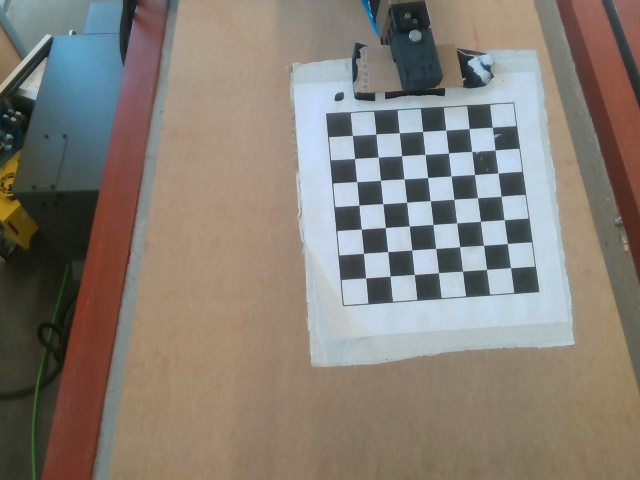

In [ ]:
# Preview image
image_path = images_path_names[0]
image = read_image(image_path)
cv2_imshow(image)

# 3. Laden van de baselink-target transformatie matrix

> Voor elke afbeelding van het dambordpatroon zullen we de transformatie matrix ${}^{C}T_{T}$ berekenen van camera frame naar target frame door middel van extrinsieke kalibratie. Om de gewenste baselink-camera transformatie ${}^{B}T_{C}$ te bekomen, hebben we nog de transformatiematrix nodig van baselink naar het target ${}^{B}T_{T}$, dit komt uit onze voorwaartse kinematica van de robot en hebben we reeds opgeslagen in /content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/baselink_target_transformations.npy. Je kan deze array printen en zien dat deze 10 keer een 4x4 transformatiematrix bevat (we hebben data van 10 afbeeldingen opgenomen). Per afbeelding hebben we dus de totale ${}^{B}T_{T}$ matrix opgeslagen. 



In [ ]:
# Get all corresponding baselink-target transformation matrices (numpy data)
baselink_target_transformations_file = '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/baselink_target_transformations.npy'
baselink_target_transformations = get_numpy_data(baselink_target_transformations_file)
print(np.shape(baselink_target_transformations))

(10, 4, 4)




> We hebben hierboven de eerste afbeelding (index 0) ingeladen en hebben nu dus ook de eerste baselink-target transformatie nodig uit de array.



In [ ]:
# Get corresponding Baselink - Target transform for the 0th image
bt_transform = baselink_target_transformations[0]
print("Baselink-target transform: \n\n" + str(bt_transform))

Baselink-target transform: 

[[ 0.16264761 -0.98452886 -0.06518191  0.11780597]
 [-0.9570397  -0.17348795  0.23232937 -0.74437628]
 [-0.24004325  0.02459386 -0.97045061  0.29724819]
 [ 0.          0.          0.          1.        ]]


> Deze matrix stelt dus de transformatiematrix voor van baselink frame {B} naar het dambordframe of targetframe {T}, ${}^{B}T_{T}$. Of in andere woorden, deze matrix kan punten beschreven in het target frame omzetten in het baselink frame. 

$$ {}^{B}P = {}^{B}T_{T}*{}^{T}P$$

> Merk op dat de getallen in de laatste kolom van boven naar beneden de x-, y-, en z-positie weergeven van het targetframe ten opzichte van het baselink frame. 

# 4. Laden van de berekende intrinsieke camera matrix

> In vorige opgave heb je de intrinsieke matrix opgelsagen, deze werd automatisch opgeslagen onder /content/drive/My Drive/object_pose_estimation_online/data/matrix_files/intrinsic_camera_properties.npz. Deze kunnen we nu laden. De functie "load_intrinsic_camera_matrix" geeft je niet enkel de intrinsieke matrix, maar ook de distrotiecoëfficiënten nodig voor de kalibratie.





In [ ]:
# Load intrinsic camera matrix and distortion coefficients
intrinsic_camera_matrix_file = '/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/intrinsic_camera_properties.npz'
mtx, dist = load_intrinsic_camera_matrix(intrinsic_camera_matrix_file)

# 5. Camera-robot kalibratie

> In dit deel zal je zelf de camera-robot calibratie uitvoeren, door terug een extrinsieke kalibratie uit te voeren en deze matrix te inverteren en te vermenigvuldingen met de baselink-target matrix. Je bekomt dus de baselink-camera transformatiematrix ${}^{B}T_{C}$. Je definieert terug de metrische coördinaten van het dambordpatroon. Je leest vervolgens een beeld uit, zet het om naar grayscale, detecteert de hoekpunten in pixels, en voert vervolgens de extrinsieke calibratie uit. 


In [ ]:
# Prepare object points in 3D space in meters
objp = get_object_points()

In [ ]:
# Read image
image = read_image(image_path)

In [ ]:
# Turn image to grayscale
gray = image_to_grayscale(image)

In [ ]:
# Find the corners in the chessbord calibration tool
corners = find_corners(gray)

In [ ]:
# Get extrinsic camera calibration matrix (camera-target transform)
ct_transform = extrinsic_calibration(objp, corners, mtx, dist)
print("Camera-target transform: \n\n" + str(ct_transform))

Camera-target transform: 

[[ 0.06693259 -0.99769695 -0.01099209  0.19001382]
 [ 0.98351275  0.06411807  0.16909037 -0.09596251]
 [-0.16799616 -0.02212852  0.98553925  0.52950329]
 [ 0.          0.          0.          1.        ]]




> Nu dat je de transformatiematrix van het cameraframe naar het targetframe ${}^{C}T_{T}$ hebt, kan de deze gebruiken samen met de ${}^{B}T_{T}$ matrix om de totale ${}^{B}T_{C}$ matrix te bekomen. Let op dat je ${}^{C}T_{T}$ eerst nog moet inverteren! De baselink-camera matrix bereken je namelijk als volgt:

$${}^{B}T_{C} = {}^{B}T_{T} * {}^{T}T_{C} $$



In [ ]:
# Invert the transform
tc_transform = invert_transform(ct_transform)

In [ ]:
# Compute Baselink - Camera transform using "multiply_transform" function
bc_transform = multiply_transforms(bt_transform, tc_transform)

In [ ]:
# Save the mean baselink - camera transformation matrix
baselink_camera_transformation_file = '/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/mean_baselink_camera_transformation'
save_to_numpy(baselink_camera_transformation_file, bc_transform)

In [ ]:
print("Baselink-camera transform: \n\n" + str(bc_transform))

Baselink-camera transform: 

[[ 0.99386435  0.08581828 -0.06977735 -0.02585932]
 [ 0.10647747 -0.9130998   0.39358774 -1.06063782]
 [-0.02993666 -0.39860253 -0.91663505  0.75004694]
 [ 0.          0.          0.          1.        ]]


# 6. Test robot-camera calibration

> In wat volgt kunnen we de robot-camera kalibratie testen. De berekende ${}^{B}T_{C}$ kan namelijk punten gedefiniëerd in robot frame omzetten in camera frame. Samen met de intrinsieke matrix kunnen we dus punten omzetten van robot frame in pixel frame en dus virtueel geplaatste objecten in robot frame visualiseren in de afbeelding. We definiëren hier een kubus in coördinaten gedefiniëerd ten opzichte van het robot frame. Je brein zal hoogst waarschijnlijk even de tijd nodig hebben om te zien dat de kubus wel degenlijk correct geplaatst is voor de robot. 






In [ ]:
# Define axis and box coordinates in camera coordinate system
box = np.float32([[-0.1, -0.6, 0], [-0.1, -0.7, 0], [-0.2, -0.7, 0], 
                  [-0.2, -0.6, 0], [-0.1, -0.6, -0.1], [-0.1, -0.7, -0.1], [-0.2, -0.7, -0.1], 
                  [-0.2, -0.6, -0.1]]).reshape(-1, 3)



> We willen nu punten gedefiniëerd in baselinkframe omzetten in camera frame. Dus hebben we de geïnverteerde nodig van ${}^{B}T_{C}$, namelijk ${}^{C}T_{B}$. 



In [ ]:
# Invert transform
cb_transform = invert_transform(bc_transform)


> Uit de berekende baselink-camera matrix kunnen we afzonderlijk het rotatie gedeelte en het translatiegedeelte uithalen. Deze dienen we afzonderlijk aan het kalibratie algoritme te geven. 

$${}^{C}T_{B} = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_{x} \\ r_{21} & r_{22} & r_{23} & t_{y} \\ r_{31} & r_{32} & r_{33} & t_{z}\\ 0 & 0 & 0 & 1 \end{bmatrix} ; {}^{C}R_{B} = \begin{bmatrix} r_{11} & r_{12} & r_{13}\\ r_{21} & r_{22} & r_{23}\\ r_{31} & r_{32} & r_{33}\end{bmatrix} ; {}^{C}t_{B} = \begin{bmatrix} t_{x} \\ t_{y} \\ t_{z}\end{bmatrix}$$

In [ ]:
# Retrieve rotation matrix and translation vector from cb_transform
cb_rot = cb_transform[:3, :3]
cb_trans = cb_transform[0:3, 3]

> Hier projecteren we de gedefiniëerde metrische coördinaten van de kubus (box) beschreven in het baselink frame in pixelcoördinaten en tekenen we deze op de afbeelding. 

In [ ]:
# Project 3D box points to pixel coordinates
imgpts_box, _ = cv2.projectPoints(box, cb_rot, cb_trans, mtx, dist)

# Draw box on image
image = draw_box1(image, imgpts_box)

> Het resultaat laat inderdaad zien dat de gedefiniëerde kubus in baselink frame coördinaten mooi de juiste pixels triggert om het effect te creëren dat deze effectief in de ruimte aanwezig is. 

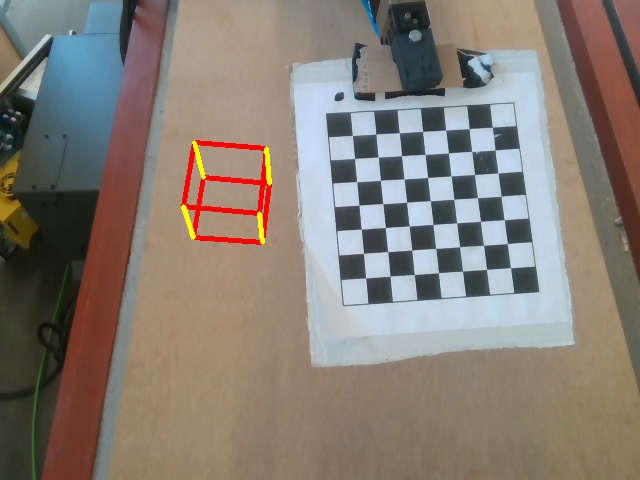

In [ ]:
# Show result
cv2_imshow(image)


> Je kan zelf wat spelen door de coördinaten van de kubus te veranderen.

